<a href="https://colab.research.google.com/github/ESIPFed/marinedata-vocabulary-guidance/blob/master/vocabulary_decision_tree_from_GForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load a bunch of libraries

In [1]:
#@title
import gspread
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import sklearn as skl

from google.colab import auth
from oauth2client.client import GoogleCredentials

## For google spreadsheet reading you need to authenticate w/ google
auth.authenticate_user()

# import decision tree package https://github.com/parrt/dtreeviz
# install if missing
try:
  from dtreeviz.trees import *
except:
  !pip install -q dtreeviz
  from dtreeviz.trees import *
  

     |████████████████████████████████| 60 kB 8.0 MB/s 


Survey responses [here](https://docs.google.com/spreadsheets/d/1txe6NpALR0yToakopUEtm_pMmk-u0fv15Ttvfgjd9rk/edit).

Pull in the data from the specified sheet and return a data frame.

In [2]:
#@title
def get_sheet_data(url: str, room_n: str) -> pd.DataFrame:
  '''
  Gets training data from each breakout room and returns as a DataFrame

  parameters:
  room_n (str): name of breakout room, eg master

  returns:
  DataFrame: training data as a DataFrame

  '''

  gc = gspread.authorize(GoogleCredentials.get_application_default())
  worksheet = gc.open_by_url(url)
  room_n = worksheet.worksheet(room_n)

  df = pd.DataFrame(room_n.get_all_records())

  df.drop(['Timestamp','Zoom Room Number'], axis=1, inplace=True)
  df.rename(
      columns={'What Controlled Vocabulary should be used with this dataset?':'CV',
               'Dataset and observation name': 'dataset'}, 
      inplace=True,
      )
  
  df.replace(to_replace=['Yes','No', 'Both equally'], value=[1,0,0.5], inplace=True)
  #df.replace(to_replace='No', value=0, inplace=True)

  return df

Takes breakout room training data and splits into X and Y  

Note: these are not being split into train and test

In [3]:
#@title
from typing import Tuple
def split_data_from_breakout_room(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Takes breakout room training data and splits into X and Y 
    Note: these are not being split into train and test

    parameters:
    df (pd.DataFrame): this should be the output of get_sheet_data()

    returns:
    X_train (pd.DataFrame): classification parameters matrix
    Y_train (pd.DataFrame): controlled vocabulary endpoints
    '''

    Y_train = df[['dataset','CV']]
    X_train = df.drop(['dataset','CV'], axis=1)
    

    return X_train, Y_train


Tree building function

In [4]:
#@title
def build_tree(X_train, Y_train, X_test, Y_test, max_depth=2):

  dec_tree_class = skl.tree.DecisionTreeClassifier(max_depth=max_depth)  

  #X_train = X_train3.to_numpy()
  X_train_flt = X_train.astype(float).to_numpy()

  #Y_train = Y_train.iloc[:,1].to_numpy().flatten()
  # controlled vocabs need to be a number, so we make a mapping
  # remove this piece if we do the mapping in the sheet
  vocab_mapping = {}
  i=0
  for vocab in Y_train['CV'].unique():
    i+=1
    vocab_mapping[vocab]=i
    Y_train['CV'].loc[Y_train['CV'] == vocab] = i

  Y_train_flt = Y_train['CV'].astype(float).to_numpy().flatten()

  dec_tree_class.fit(X_train_flt, Y_train_flt)

  viz = dtreeviz(dec_tree_class, 
                X_train_flt,
                Y_train_flt,
                target_name='Controlled Vocabulary',
                feature_names=X_train.columns, 
                #class_names=["CF", "GCMD", "NERC","WoRMS"],
                class_names=list(vocab_mapping.keys()),
                #orientation='LR',
                orientation='UD',
                scale=2,
                title='0 = No\n1 = Yes',
                )

  return viz

Put everything together into one function

In [5]:
#@title
# function to run through them

def build_tree_from_spreadsheet(train_url, sheet):
  
  training = get_sheet_data(train_url, sheet)
  X_train, Y_train = split_data_from_breakout_room(training)
  X_test = X_train
  Y_test = Y_train
  viz = build_tree(X_train, Y_train, X_test, Y_test, max_depth=5)

  return viz


Run the function and display the chart

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


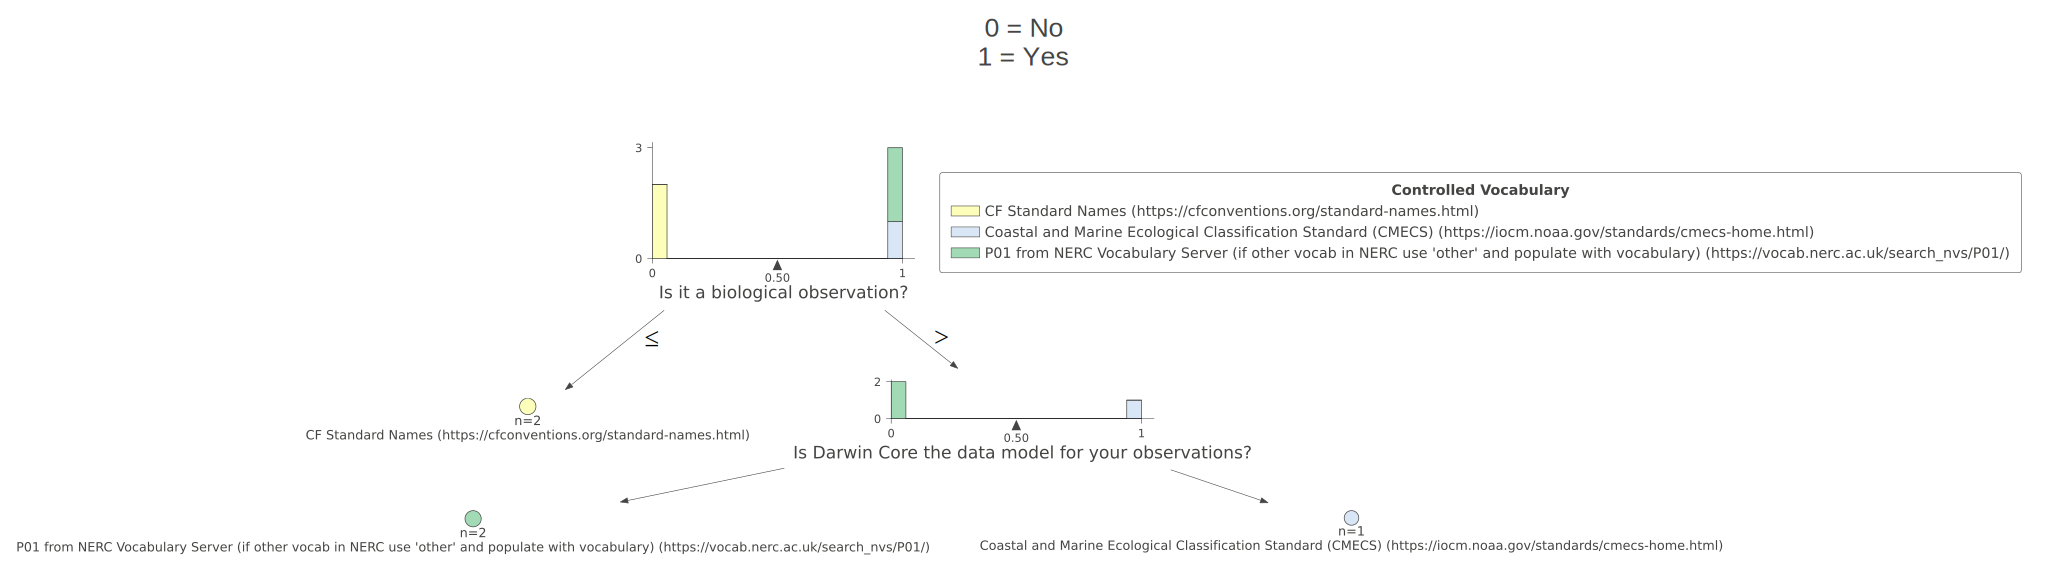

In [6]:
# load in the google form responses
import warnings
warnings.filterwarnings("ignore")
train_url = 'https://docs.google.com/spreadsheets/d/1txe6NpALR0yToakopUEtm_pMmk-u0fv15Ttvfgjd9rk'
viz = build_tree_from_spreadsheet(train_url,'Form Responses 1')
viz

In [ ]:
viz.save('dtree.svg')